In [48]:
# Initial imports
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from datetime import date
import datetime
from datetime import timedelta
import plotly.express as px
import plotly.graph_objects as go
import hvplot.pandas

# Note: Consolidate API calls in data_service module
import data_service as ds

%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv()

True

In [4]:
# Get API keys
coin_api_key = os.getenv('COIN_API_KEY') 
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [4]:
# type(coin_api_key)

In [5]:
# Common date params
start_date = '2016-01-01'
end_date = '2021-01-01'

## Historical OHLCV - Crypto

In [6]:
# BTC historical OHLCV
btc_df = ds.get_crypto_OHLCV(coin_api_key, 'BTC', start_date, end_date, '1DAY')
btc_df.head()

,date,open,high,low,close,volume
0,2016-01-02,430.35,437.15,427.20000,433.82,7665.737205
1,2016-01-03,435.67,437.56,430.32476,435.40,6274.264733
2,2016-01-04,433.20,435.75,422.98000,431.91,8499.043386
3,2016-01-05,431.54,435.86,426.56000,434.17,11652.260666
4,2016-01-06,433.31,435.64,429.00000,433.34,9065.912403


In [7]:
# ETH historical OHLCV
eth_df = ds.get_crypto_OHLCV(coin_api_key, 'ETH', start_date, end_date, '1DAY')
eth_df.head()

,date,open,high,low,close,volume
0,2016-05-10,12.00,12.00,9.36,9.98,1317.902740
1,2016-06-10,14.65,14.70,14.57,14.65,1918.261279
2,2016-06-11,14.19,14.26,13.76,13.91,6847.468569
3,2016-06-12,13.93,14.29,13.86,14.10,7331.345783
4,2016-06-13,14.14,15.91,13.92,15.58,19734.452652


In [8]:
# XRP historical OHLCV
xrp_df = ds.get_crypto_OHLCV(coin_api_key, 'XRP', start_date, end_date, '1DAY')
xrp_df.head()

,date,open,high,low,close,volume
0,2017-01-26,0.00645,0.00650,0.00645,0.00649,5.352321e+05
1,2017-01-27,0.00650,0.00650,0.00638,0.00638,3.666513e+05
2,2017-02-02,0.00642,0.00642,0.00642,0.00642,1.283484e+04
3,2017-02-08,0.00643,0.00643,0.00626,0.00641,3.754936e+05
4,2017-02-09,0.00635,0.00648,0.00608,0.00635,3.180308e+06


In [9]:
# Chainlink historical OHLCV
link_df = ds.get_crypto_OHLCV(coin_api_key, 'LINK', start_date, end_date, '1DAY')
link_df.head()

,date,open,high,low,close,volume
0,2019-06-28,2.80099,2.80099,2.05000,2.31980,307968.63
1,2019-06-29,2.31980,3.60000,2.20000,3.18477,5414269.76
2,2019-06-30,3.18398,5.10000,2.92001,3.80122,26581200.93
3,2019-07-01,3.84892,4.24990,3.20101,3.41950,12033346.61
4,2019-07-02,3.38060,3.98880,2.83100,3.62996,12309440.40


In [30]:
# LTC historical OHLCV
ltc_df = ds.get_crypto_OHLCV(coin_api_key, 'LTC', start_date, end_date, '1DAY')
ltc_df.head()

,date,open,high,low,close,volume
0,2016-02-06,3.18320,3.18321,3.10001,3.11000,15.136716
1,2016-02-07,3.10520,3.12660,3.04500,3.11840,272.718989
2,2016-02-08,3.11129,3.11129,3.03000,3.03000,285.866103
3,2016-02-09,3.03000,3.07999,2.93229,2.98943,864.634952
4,2016-02-10,2.99082,3.07999,2.99082,3.05000,979.004886


In [10]:
# Stellar Lumens historical OHLCV
xlm_df = ds.get_crypto_OHLCV(coin_api_key, 'XLM', start_date, end_date, '1DAY')
xlm_df.head()

,date,open,high,low,close,volume
0,2017-01-21,0.002250,0.003000,0.002250,0.002957,5.339573e+05
1,2017-01-22,0.002251,0.002500,0.002250,0.002500,1.410111e+06
2,2017-01-23,0.002377,0.002397,0.002253,0.002253,2.549354e+05
3,2017-01-24,0.002257,0.002272,0.002257,0.002272,3.763656e+05
4,2017-01-25,0.002275,0.002275,0.002206,0.002212,7.377240e+06


## Historical OHLCV - Stocks

In [11]:
# SPY historical OHLCV
spy_df = ds.get_stock_OHLCV(alpaca_api_key, alpaca_secret_key, 'SPY', start_date, end_date, '1D')
spy_df.head()

,date,open,high,low,close,volume
0,2016-01-04,200.50,201.03,198.59,200.99,151908002
1,2016-01-05,201.40,201.90,200.05,201.43,90242524
2,2016-01-06,198.34,200.06,197.60,198.79,118917648
3,2016-01-07,195.33,198.82,193.59,194.01,174230042
4,2016-01-08,195.19,195.85,191.58,191.89,157703921


In [12]:
# GLD historical OHLCV
gld_df = ds.get_stock_OHLCV(alpaca_api_key, alpaca_secret_key, 'GLD', start_date, end_date, '1D')
gld_df.head()

,date,open,high,low,close,volume
0,2016-01-04,103.13,103.670,102.485,102.87,5226833
1,2016-01-05,103.13,103.460,102.930,103.18,2968407
2,2016-01-06,104.39,104.800,103.930,104.66,8212823
3,2016-01-07,105.83,106.237,105.190,106.15,9614677
4,2016-01-08,105.48,105.800,105.040,105.66,6001522


## Daily Returns

In [31]:
# Get daily returns
btc_returns_df = ds.get_pct_chg_for_OHLCV(btc_df)
eth_returns_df = ds.get_pct_chg_for_OHLCV(eth_df)
xrp_returns_df = ds.get_pct_chg_for_OHLCV(xrp_df)
link_returns_df = ds.get_pct_chg_for_OHLCV(link_df)
ltc_returns_df = ds.get_pct_chg_for_OHLCV(ltc_df)
xlm_returns_df = ds.get_pct_chg_for_OHLCV(xlm_df)
spy_returns_df = ds.get_pct_chg_for_OHLCV(spy_df)
gld_returns_df = ds.get_pct_chg_for_OHLCV(gld_df)

In [26]:
btc_returns_df.head()

,close
date,
2016-01-02,NaN
2016-01-03,0.003642
2016-01-04,-0.008016
2016-01-05,0.005233
2016-01-06,-0.001912


In [76]:
# Combine daily returns
# combined_daily_returns = pd.concat(
#     [btc_returns_df, eth_returns_df, xrp_returns_df, ltc_returns_df, xlm_returns_df, spy_returns_df, gld_returns_df], 
#     axis="columns", 
#     join="inner")
combined_daily_returns = pd.concat(
    [btc_returns_df, eth_returns_df, xrp_returns_df, ltc_returns_df, spy_returns_df, gld_returns_df], 
    axis="columns", 
    join="inner")

combined_daily_returns = combined_daily_returns.dropna()

# Rename columns
combined_daily_returns.columns = ['BTC','ETH','XRP','LTC','SPY','GLD']

# Ensure we are sorted by date (index)
combined_daily_returns.sort_index()

# Filter out everything before 2018
combined_daily_returns = combined_daily_returns.loc[datetime.date(year=2020,month=1,day=1):]

# Verify
combined_daily_returns.head()

,BTC,ETH,XRP,LTC,SPY,GLD
date,,,,,,
2020-01-02,0.000833,0.012443,0.002028,0.008262,0.009165,0.007066
2020-01-03,-0.032342,-0.025962,-0.029529,-0.052302,-0.007388,0.013547
2020-01-06,0.000921,0.008722,0.009449,0.012637,0.003815,0.010487
2020-01-07,0.055637,0.065627,0.149000,0.058239,-0.002812,0.004002
2020-01-08,0.050729,-0.007698,-0.043420,0.012230,0.005143,-0.007702


Text(0, 0.5, 'Percentage Change')

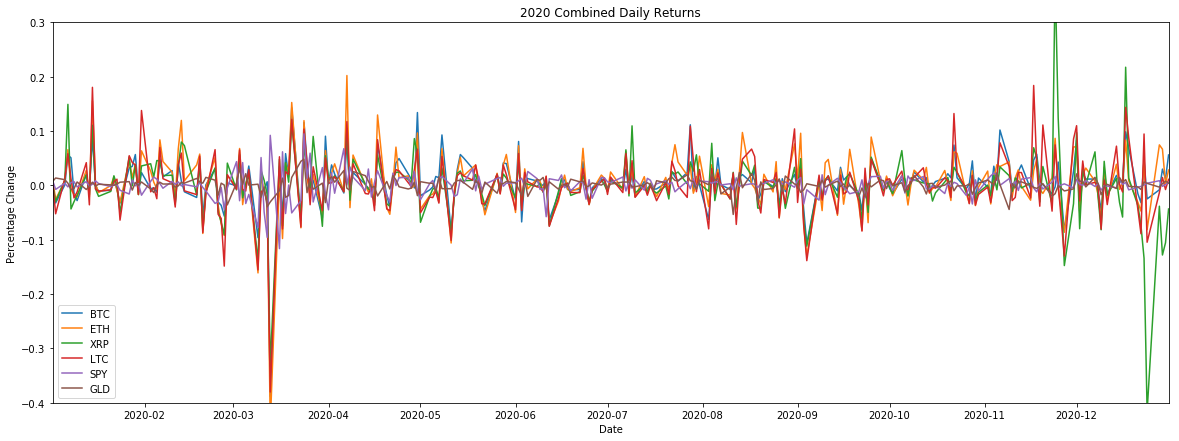

In [79]:
# Plot combined daily returns
ax_daily_returns = combined_daily_returns.plot(title='2020 Combined Daily Returns', figsize=(20,7), fontsize=10, ylim=(-.4,.3), legend=True)

ax_daily_returns.set_xlabel("Date")
ax_daily_returns.set_ylabel("Percentage Change")

Text(0, 0.5, 'Cumulative Return')

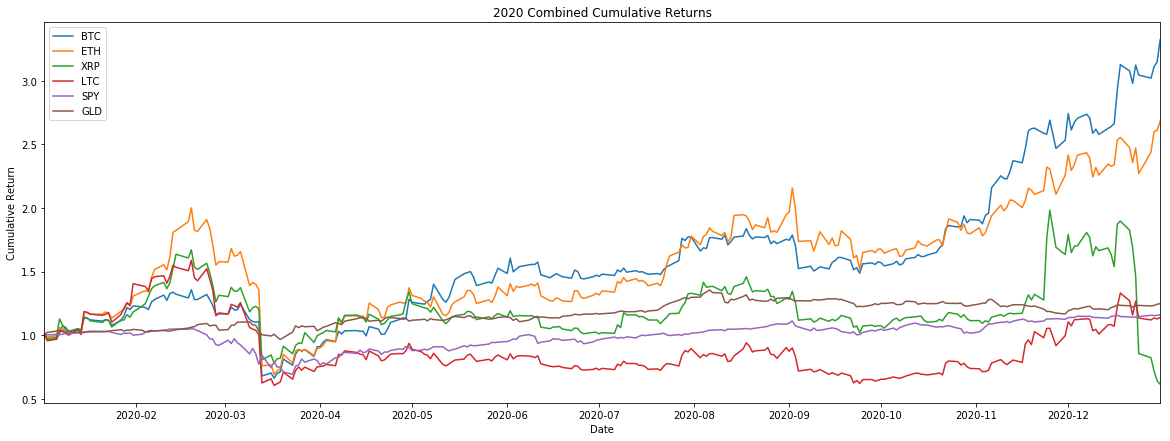

In [80]:
combined_cumulative_returns = (1 + combined_daily_returns).cumprod()
ax_cum_returns = combined_cumulative_returns.plot(title='2020 Combined Cumulative Returns', figsize=(20,7), fontsize=10, legend=True)
ax_cum_returns.set_xlabel("Date")
ax_cum_returns.set_ylabel("Cumulative Return")

In [27]:
# Plot using Pandas
# spy_returns_df.plot(title='SPY Daily Returns', figsize=(20,7), fontsize=10, ylim=(-.07,.07), legend=True)

In [27]:
# Define main plot
main_plot = btc_returns_df.hvplot.line(
    x='date',
    y='close',
    xlabel='Date',
    ylabel='Percentage change',
    title='Daily Returns',
    width=1000)

In [28]:
# Define additional plot figures
eth_plot = eth_returns_df.hvplot.line(x='date', y='close')
xrp_plot = xrp_returns_df.hvplot.line(x='date', y='close')
link_plot = link_returns_df.hvplot.line(x='date', y='close')
xlm_plot = xlm_returns_df.hvplot.line(x='date', y='close')
spy_plot = spy_returns_df.hvplot.line(x='date', y='close')
gld_plot = gld_returns_df.hvplot.line(x='date', y='close')

In [29]:
# Plot all assets
main_plot * eth_plot * xrp_plot * link_plot * xlm_plot * spy_plot * gld_plot

:Overlay
   .Curve.I   :Curve   [date]   (close)
   .Curve.II  :Curve   [date]   (close)
   .Curve.III :Curve   [date]   (close)
   .Curve.IV  :Curve   [date]   (close)
   .Curve.V   :Curve   [date]   (close)
   .Curve.VI  :Curve   [date]   (close)
   .Curve.VII :Curve   [date]   (close)